In [25]:
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

conn = duckdb.connect()

conn.query("""
               INSTALL httpfs;
               LOAD httpfs;
                CREATE SECRET secretaws (
                TYPE S3, 
                URL_STYLE 'path',
                ENDPOINT 'localhost:9000',
                KEY_ID 'minioRootUser',
                SECRET 'iLoveCoding1234',
                REGION 'us-east-1',
                USE_SSL FALSE
            );
               """)

┌─────────┐
│ Success │
│ boolean │
├─────────┤
│ true    │
└─────────┘

In [26]:
df1 = conn.query("""
                SELECT wiki, count(wiki) 
                FROM read_parquet('s3://wikichanges/topics/wikimedia.recentchange/partition=0/wikimedia.recentchange*.parquet') as s1
                WHERE bot = false and type in ('edit', 'new') and wiki not in ('wikidatawiki', 'commonswiki') and namespace = 0 and length.new<>length.old
                GROUP BY wiki
                HAVING count(wiki) > 10
                """)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

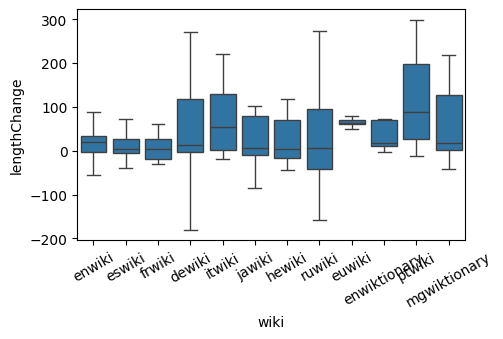

In [27]:
df2 = conn.query("""
                SELECT df2.wiki, length.new-length.old as lengthChange 
                FROM read_parquet('s3://wikichanges/topics/wikimedia.recentchange/partition=0/wikimedia.recentchange*.parquet') as df2
                INNER JOIN df1 on df1.wiki = df2.wiki
                WHERE bot = false and type in ('edit', 'new') and df2.wiki not in ('wikidatawiki', 'commonswiki') and namespace=0 and length.new<>length.old
                """)

f, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.xticks(rotation=30)

ax = sns.boxplot(x='wiki', y='lengthChange', data=df2.df(), showfliers=False)

plt.show()